# Automated Patent Landscaping

This notebook walks through the process of creating a patent landscape as described in the paper [Automated Patent Landscaping](AutomatedPatentLandscaping.pdf) (Abood, Feltenberger 2016). The basic outline is:
* load pre-trained word embeddings
* load a seed set of patents and generate the positive and negative training data
* train a deep neural network on the data
* show how to do inference using the model

If you haven't already, please make sure you've setup an environment following the instructions in the [README](README.md) so you have all the necessary dependencies.

Copyright 2017 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Basic Configuration

In [1]:
import tensorflow as tf
import pandas as pd
import os

# ensures TensorFlow only uses the GPU memory it needs rather than all (the default)
GPU_MEM_CONFIG = tf.ConfigProto(gpu_options={'allow_growth': True})
#seed_file = 'seeds/3d_gesture.seed.csv'
seed_name = 'hair_dryer_nocpc'
seed_file = 'seeds/hair_dryer_large.seed.csv'
# BigQuery must be enabled for this project
bq_project = 'patent-landscape-165715' #Replace this with your Google Cloud project name!
patent_dataset = 'patents-public-data:patents.publications_latest'
num_anti_seed_patents = 15000
gcs_models_url = 'https://console.cloud.google.com/storage/browser/patent_landscapes/models'

## Download Model(s) if Necessary


In [2]:
from word2vec import W2VModelDownload

model_name = '5.9m'
model_download = W2VModelDownload()
model_download.download_w2v_model('patent_landscapes', model_name)
print('Done downloading model {}!'.format(model_name))

Model 5.9m already exists. Using local copy.
Done downloading model 5.9m!


## Load Word2Vec Embeddings

This loads Word2Vec embeddings from a model trained on 5.9 million patent abstracts. Just as a demonstration, this also finds the k most similar words to a given word ranked by closeness in the embedding space. Finally, we use tSNE to visualize the word closeness in 2-dimensional space.

Note that the actual model files are fairly large (e.g., the 5.9m dataset is 760mb per checkpoint), so they are not stored in the Github repository. They're stored in the [patent_landscapes](https://console.cloud.google.com/storage/browser/patent_landscapes) Google Cloud Storage bucket under the models/ folder. If you'd like to use them, download the `models` folder and put it into the root repository folder (e.g., if you checked out this repository into the `patent-models` folder, then the `5.9m` model should be in `patent-models/models/5.9m`, for example.

In [3]:
from word2vec import Word2Vec

word2vec5_9m = Word2Vec('5.9m')
w2v_runtime = word2vec5_9m.restore_runtime()

Will use models/5.9m directory to load/persist model information.
INFO:tensorflow:Restoring parameters from models/5.9m/checkpoints/5.9m_abstracts.ckpt-1325000


In [38]:
w2v_runtime.find_similar('hair', 10)

[{'distance': 0.27630660661697637, 'index': 12541, 'word': 'styling'},
 {'distance': 0.32142541152072901, 'index': 10423, 'word': 'scalp'},
 {'distance': 0.36028437798177293, 'index': 12575, 'word': 'hairs'},
 {'distance': 0.38895442679570091, 'index': 3634, 'word': 'cosmetic'},
 {'distance': 0.39621903141812476, 'index': 9330, 'word': 'keratin'},
 {'distance': 0.40511075285155751, 'index': 13313, 'word': 'keratinous'},
 {'distance': 0.4064818428717476, 'index': 1239, 'word': 'skin'},
 {'distance': 0.42916966797624234, 'index': 13269, 'word': 'shampoo'},
 {'distance': 0.43838439284560793, 'index': 12240, 'word': 'cosmetically'},
 {'distance': 0.44125860932789462, 'index': 16618, 'word': 'curler'}]

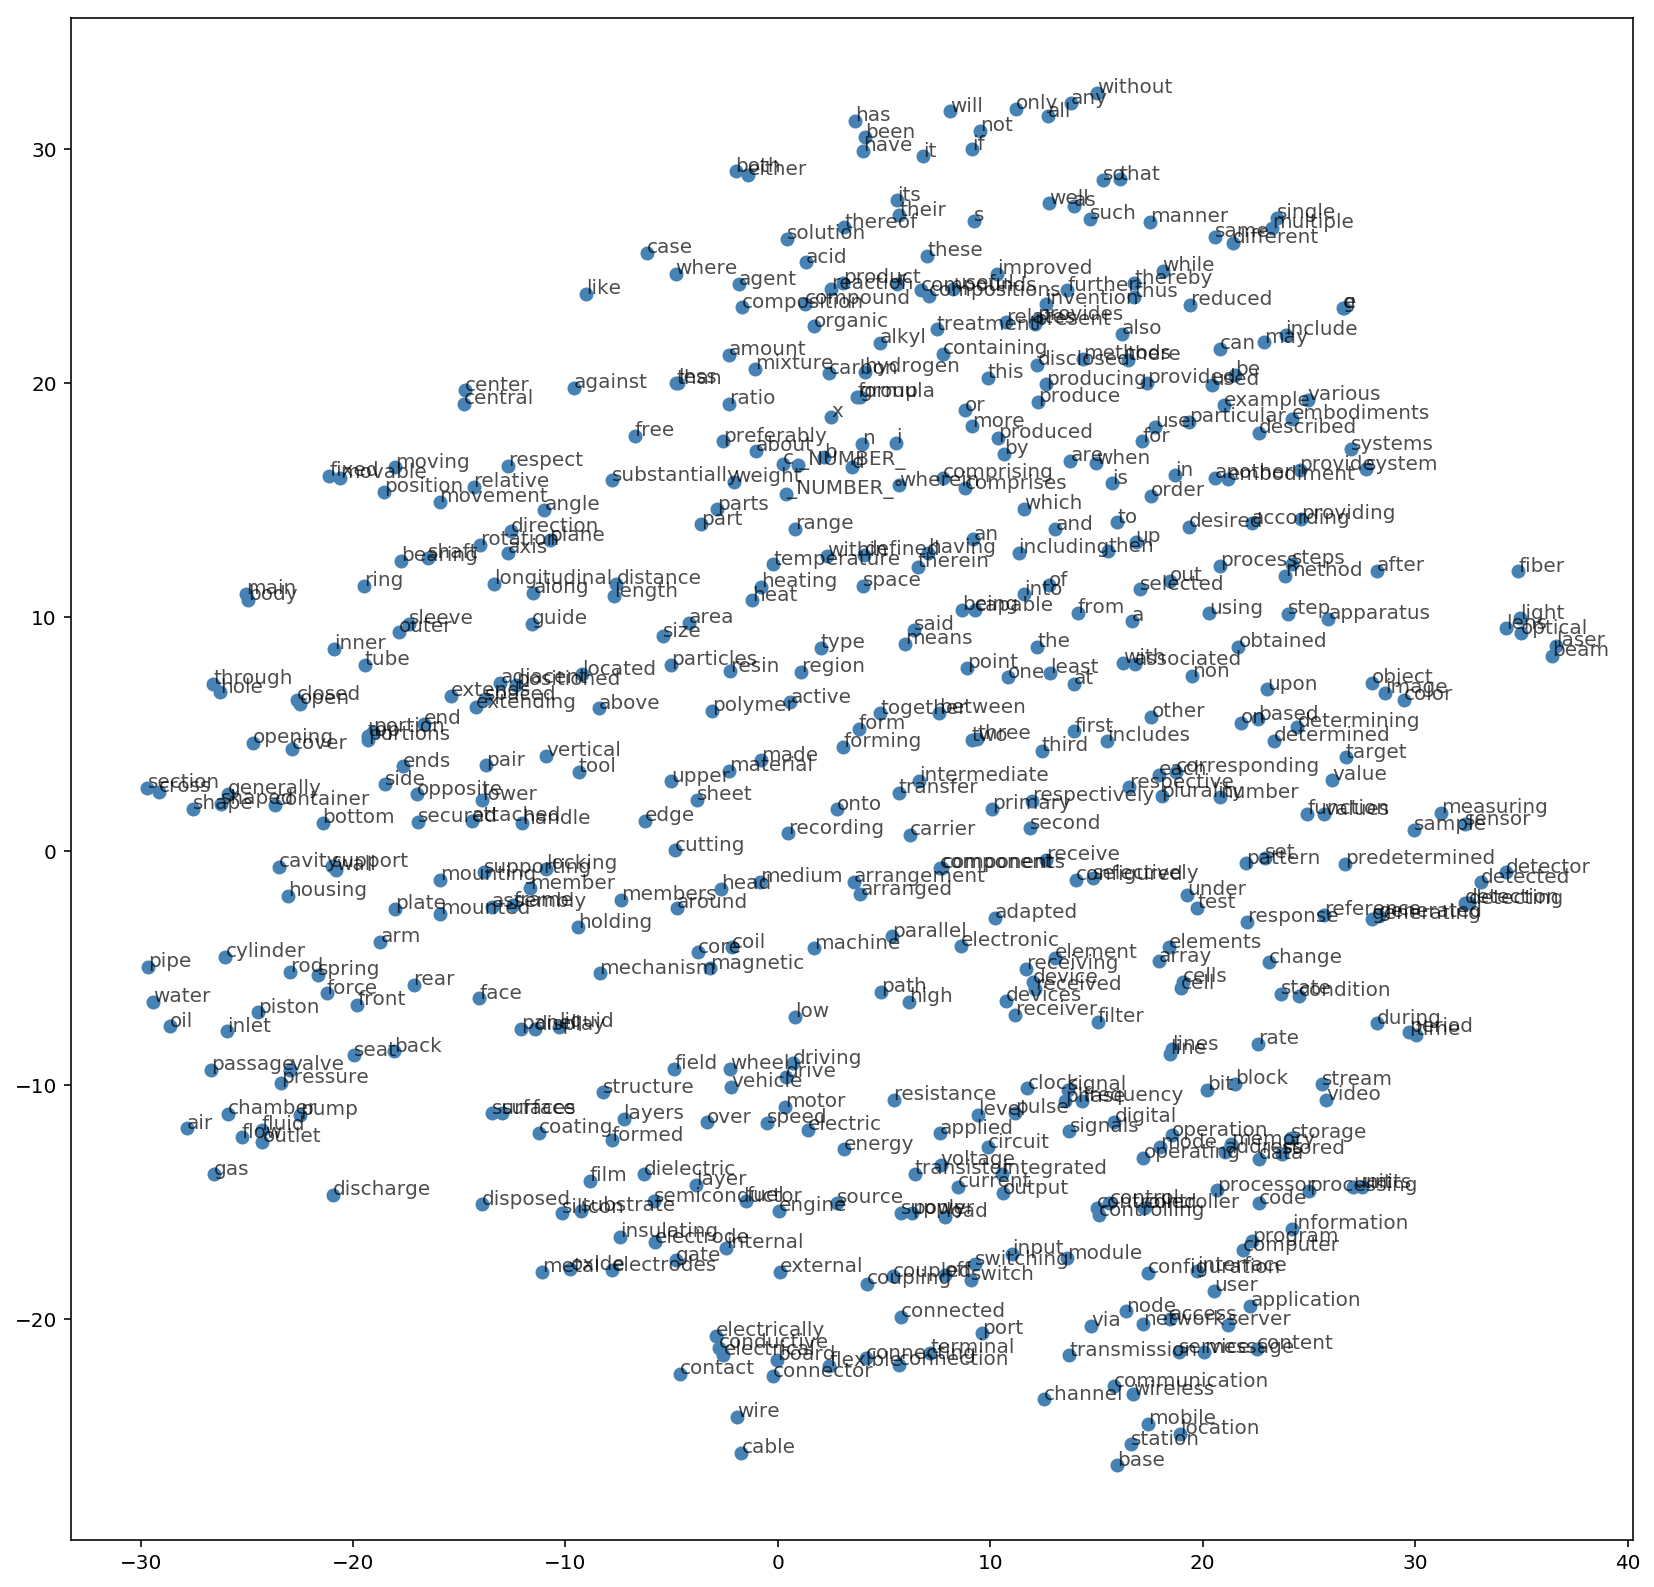

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

w2v_runtime.visualize_embeddings(500)

## Patent Landscape Expansion

This section of the notebook creates an instance of the `PatentLandscapeExpander`, which accesses a BigQuery table of patent data to do the expansion of a provided seed set and produces each expansion level as well as the final training dataset as a Pandas dataframe.

In [4]:
import expansion

expander = expansion.PatentLandscapeExpander(
    seed_file,
    seed_name,
    bq_project=bq_project,
    patent_dataset=patent_dataset,
    num_antiseed=num_anti_seed_patents)


This does the actual expansion and displays the head of the final training data dataframe.

In [5]:

training_data_full_df, seed_patents_df, l1_patents_df, l2_patents_df, anti_seed_patents = \
    expander.load_from_disk_or_do_expansion()

training_df = training_data_full_df[
    ['publication_number', 'title_text', 'abstract_text', 'claims_text', 'description_text', 'ExpansionLevel', 'refs', 'cpcs']]
training_data_full_df.head()


Loading landscape data from BigQuery.
Querying for all US CPC Counts
Querying for Seed Set CPC Counts
Querying to find total number of US patents
Got 1609 relevant seed refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (1609, 1), to patents._l1_tmp
Completed loading temp table.
Shape of L1 expansion: (1877, 3)
Got 10289 relevant L1->L2 refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (10289, 1), to patents._l2_tmp
Completed loading temp table.
Shape of L2 expansion: (7681, 3)
Size of union of [Seed, L1, and L2]: 8127
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (8127, 1), to patents.antiseed_tmp
Completed loading temp table.
Loading training data text from (15325, 2) publication numbers
Loading dataframe with cols Index(['publication_number'], dtype='object'), shape (15325, 1), to patents._tmp_training
Completed loading temp table.
Loading patent texts from provided publication numbers.
Merging labels into trai

,pub_num,publication_number,family_id,priority_date,title_text,abstract_text,claims_text,description_text,refs,cpcs,ExpansionLevel
0,5849183,US-5849183-A,24834772,19960830,Filtration apparatus,"A filtration apparatus, used for obtaining cut...",unused,unused,"US-1904066-A,US-1904066-A,US-1904066-A,US-1904...","B01D2201/282,B01D2201/34,B01D33/073,B01D2201/0...",AntiSeed
1,2004156487,US-2004156487-A1,32820840,20030206,Messaging system,A wireless tag 1 carried by a user sends a u...,unused,unused,"US-6400272-B1,US-6400272-B1,US-6400272-B1,US-6...","H04L67/18,H04M3/53333,H04W4/02,H04L12/5855,H04...",AntiSeed
2,7044411,US-7044411-B2,32994325,20030206,Method of winding sheeting with filler strips,A method of rolling a membrane sheeting having...,unused,unused,"US-2589202-A,US-2589202-A,US-2589202-A,US-2589...","Y10S428/906,B32B3/14,E04D5/142,E04D5/148,E04D5...",AntiSeed
3,7055871,US-7055871-B2,34068453,20030718,Electronic door lock dogging mechanism,An electronic door lock dogging mechanism is p...,unused,unused,"US-1391005-A,US-1391005-A,US-1391005-A,US-1391...","Y10T292/1021,Y10T292/546,Y10T292/699,Y10T70/53...",AntiSeed
4,7351731,US-7351731-B2,34083429,20030718,Azole derivatives and methods for making the same,The present invention is broadly directed to a...,unused,unused,"US-4992454-A,US-4992454-A,US-4992454-A,US-4992...","C07D249/08,C07D403/06,C07F9/65586,C07F9/65181,...",AntiSeed


### Show some stats about the landscape training data

In [6]:
print('Seed/Positive examples:')
print(training_df[training_df.ExpansionLevel == 'Seed'].count())

print('\n\nAnti-Seed/Negative examples:')
print(training_df[training_df.ExpansionLevel == 'AntiSeed'].count())

Seed/Positive examples:
publication_number    261
title_text            261
abstract_text         261
claims_text           261
description_text      261
ExpansionLevel        261
refs                  261
cpcs                  261
dtype: int64


Anti-Seed/Negative examples:
publication_number    9812
title_text            9812
abstract_text         9812
claims_text           9812
description_text      9812
ExpansionLevel        9812
refs                  9812
cpcs                  9812
dtype: int64


## Preparing / Transforming Training Data

The following takes the input landscape training dataframe and transforms it into a format readable by TensorFlow and Keras.

In [7]:
import train_data
import tokenizer

# TODO: persist this tokenization data too
td = train_data.LandscapeTrainingDataUtil(training_df, w2v_runtime)
td.prepare_training_data(
    training_df.ExpansionLevel,
    training_df.abstract_text,
    training_df.refs,
    training_df.cpcs,
    0.8,
    50000,
    500)


Using TensorFlow backend.


No Keras tokenizer supplied so using vocab size (50000) and series to build new one
No Keras tokenizer supplied so using vocab size (500) and series to build new one
Randomizing training data
Creating NumPy arrays for train/test set out of randomized training data.
Train (embed) data shapes: train: (8058,), train labels shape: (8058,)
Test (embed) data shape: (2015,), test labels shape: (2015,)
doc lengths for embedding layer: median: 104, mean: 105.1945892280963, max: 474
Using sequence length of 474 to pad LSTM sequences.
Training data ready.


### Show some sample training data

In [8]:
pos_idx = -1
neg_idx = -1
for idx in range(0, len(td.prepped_labels)):
    if td.prepped_labels[idx] == 0 and pos_idx < 0:
        pos_idx = idx
    if td.prepped_labels[idx] == 1 and neg_idx < 0:
        neg_idx = idx

    if pos_idx > -1 and neg_idx > -1:
        break

print('Showing positive example (instance #{}).'.format(pos_idx))
td.show_instance_details(pos_idx)
print('\n------------------------------------\n')
print('Showing negative example (instance #{}).'.format(neg_idx))
td.show_instance_details(neg_idx)


Showing positive example (instance #5).

Original: A ceramic-containing sleeve or a ceramic-based coating on the surface of a roller or curler. The coating or sleeve comprises a mixture of components including, substantially, silicon oxide. While the present invention rollers emit ions without application of heat, heat may be applied to a roller via a conventional blow dryer or other hair dryer to achieve other results and to enhance ion emission. The ceramic materials also provide enhanced performance in terms of heat transfer, retention and distribution.
Tokenized: a ceramic containing sleeve or a ceramic based coating on surface of a roller or curler coating or sleeve comprises a mixture of components including substantially silicon oxide while present invention rollers emit ions without application of heat heat may be applied to a roller via a conventional blow dryer or other hair dryer to achieve other results and to enhance ion emission ceramic materials also provide enhanced per

# Train Model

The following cells specify hyperparameters, the neural network architecture (using Keras) and actually trains and tests the model.

The model is generally composed of:
* sequential word embeddings from the patent Abstract of each training instance
* references one-hot encoded into a fully-connected layer
* CPC codes one-hot encoded into a fully-connected layer
* the above three layers concatenated into a final fully-connected layer
* a final, single sigmoid layer with the classification result


### Model Hyperparameters

In [9]:
batch_size = 32
dropout_pct = 0.4

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_size = 128


### Build the Deep Neural Network

In [10]:
import model
import importlib
importlib.reload(model)

model = model.LandscapeModel(td, 'data', seed_name)
model.wire_model(lstm_size, dropout_pct)

Building model graph...
Done building graph.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 364)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                23360     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
elu_5 (ELU)                  (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 46,173,213
Trainable params: 13,099,845
Non-trainable params: 33,073,368
__________

/usr/local/google/home/feltenberger/src/models/patent-models-test/model.py:94: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  model.add(Merge([refs, deep], mode='concat', concat_axis=1))


### Train / Fit the Network

In [11]:
model.train_or_load_model(batch_size)

Model has not been trained yet.
Training model.
Train on 8058 samples, validate on 2015 samples
Epoch 1/5
8058/8058 [==============================] - 153s - loss: 0.2261 - acc: 0.9269 - precision: 0.9802 - recall: 0.9443 - fmeasure: 0.9586 - val_loss: 0.0788 - val_acc: 0.9772 - val_precision: 0.9780 - val_recall: 0.9990 - val_fmeasure: 0.9882
Epoch 2/5
8058/8058 [==============================] - 153s - loss: 0.0833 - acc: 0.9806 - precision: 0.9834 - recall: 0.9970 - fmeasure: 0.9900 - val_loss: 0.0612 - val_acc: 0.9811 - val_precision: 0.9824 - val_recall: 0.9985 - val_fmeasure: 0.9903
Epoch 3/5
8058/8058 [==============================] - 152s - loss: 0.0588 - acc: 0.9849 - precision: 0.9881 - recall: 0.9964 - fmeasure: 0.9921 - val_loss: 0.0750 - val_acc: 0.9787 - val_precision: 0.9908 - val_recall: 0.9871 - val_fmeasure: 0.9888
Epoch 4/5
8058/8058 [==============================] - 152s - loss: 0.0508 - acc: 0.9871 - precision: 0.9903 - recall: 0.9966 - fmeasure: 0.9933 - val_los

### Evaluate the Model on the Test Set

In [12]:
score, acc, p, r, f1 = model.evaluate_model(batch_size)

2001/2001 [==============================] - 7s     

Test score: 0.0070
Test accuracy: 0.9980
Test p/r (f1): 1.00/1.00 (1.00)


------

# Inference

*NOTE*: the below inference code assumes you've already trained a model _in the currently active kernel_ such that the following variables are already set:
* `model` is the Keras-trained DNN
* `l1_patents_df` is the dataframe returned by the PatentLandscapeExpander

Future iterations will save model checkpoints and allow saving off models and then loading them later just for inference.

### Load Inference Data

This randomly selects a subset of the L1 patents (that we got from reference and CPC expansions) and loads the details (text, CPCs, refs, etc.) from BigQuery.

In [22]:

subset_l1_pub_nums, l1_texts, padded_abstract_embeddings, refs_one_hot, cpc_one_hot = \
    expander.sample_for_inference(td, 1.0)


Loading inference data from filesystem at data/hair_dryer/landscape_inference_data.pkl


#### Classification of L1

We use a very rough heuristic to determine what the "ground truth" is for our L1 expansion -- whether something contains both the string "hair" and "dry"; if it does, we consider it a positive example; if not, we consider it a negative example. We can explore our false negatives and negatives below in the confusion matrix.

In [23]:
predictions = model.batch_predict(padded_abstract_embeddings, refs_one_hot, cpc_one_hot)

In [25]:
l1_texts['score'] = pd.DataFrame(predictions, columns=['score'])['score']
l1_texts['label'] = 'Seed'
l1_texts[['publication_number', 'score', 'label', 'abstract_text', 'refs', 'cpcs']]
l1_texts['has_hair'] = l1_texts.abstract_text.str.lower().str.contains('hair')
l1_texts['has_dry'] = l1_texts.abstract_text.str.lower().str.contains('dry')
l1_texts.loc[(l1_texts.has_hair == False) & (l1_texts.has_dry == False), 'label'] = 'AntiSeed'
l1_texts['cpcs'].iloc[0]


'A45D20/10,A45D20/08,A45D20/10,A45D20/08,A45D20/10,A45D20/08,A45D20/10,A45D20/08,A45D20/10,A45D20/08'

             precision    recall  f1-score   support

       seed       0.78      0.99      0.87       826
   antiseed       0.97      0.66      0.79       660

avg / total       0.87      0.84      0.84      1486

Confusion matrix:
[[814  12]
 [224 436]]


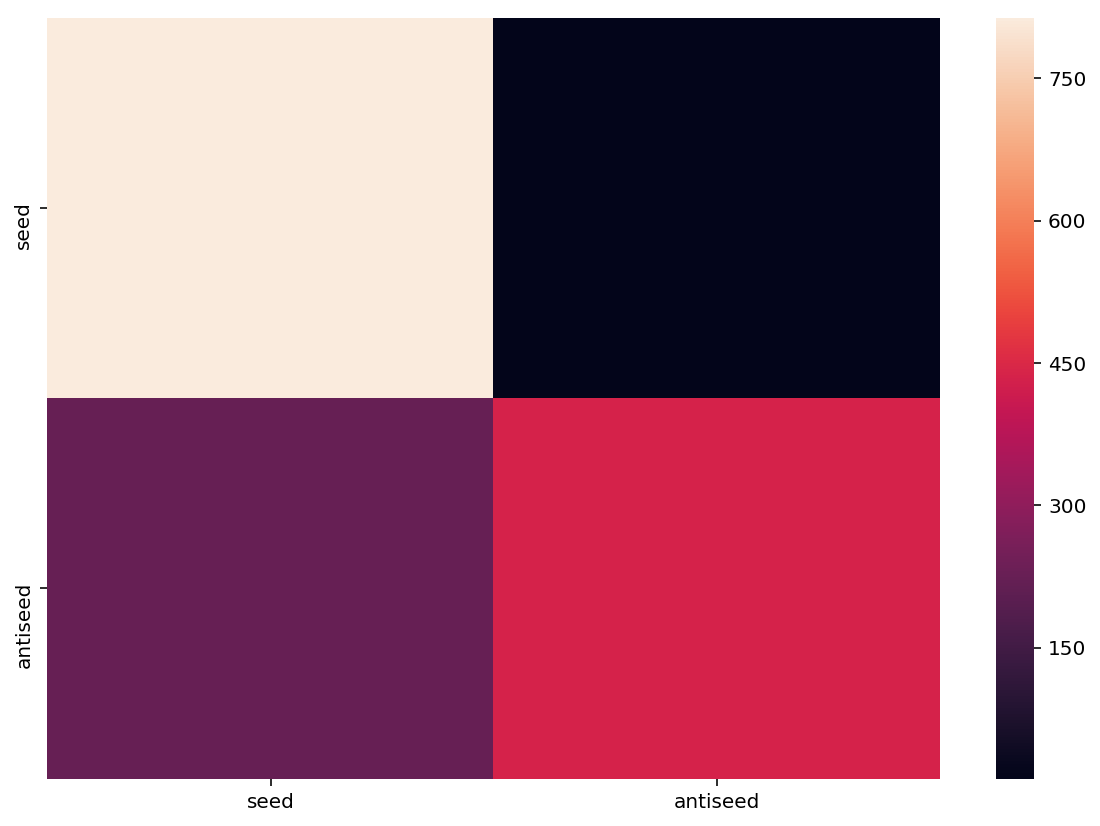

In [33]:
classify_report, confusion_matrix = model.reports(l1_texts)

print(classify_report)

print('Confusion matrix:\n{}'.format(confusion_matrix))
model.show_confusion_matrix(confusion_matrix)

In [26]:
predicted_seed_class = l1_texts.score <= 0.5
predicted_nonseed_class = l1_texts.score > 0.5

l1_texts[
    (predicted_nonseed_class) & (l1_texts.has_hair == False) & (l1_texts.has_dry == False)
  ].abstract_text.iloc[1]


'An adjustable bracket adapted to be secured to a rigid surface and firmly held in a selected position over a wide range. Its paramount advantage is the ease with which the adjusted position may be realized and the object rigidly held therein against vibration and shock.'

#### Ad-hoc classification
If you want to experiment with ad-hoc classification of data, edit the fields below for abstract text, references, and CPC codes to see how it influences the model's output. Somewhat counter-intuitively, a score closer to 0 means more likely to be an instance of the seed class (e.g., more likely to be about 'hair dryers').

In [18]:
# A conditioner infuser cartridge for use with a dryer attachment having an attachment end for engagement with a hair dryer barrel, an opposite air outlet end and a perforated portion between the ends having at least one air intake, the cartridge configured for engagement near the attachment end and including a conditioner element constructed and arranged for retaining a supply of vaporizable conditioner and a support frame receiving the conditioner element and securing same in the attachment.
# An electric lamp bulb or electric resistance coil is provided to radiate heat to one or more adjacent surfaces which have an active oxidation catalyst such that fumes and odors in the confines of a room that are drawn over the catalytic surface will be converted to less objectionable products. A catalytic device with an incandescent light bulb type of heating element is of particular advantage in that it can readily be screwed into a lamp base or mounted in other forms of current supplying receptacles and, in addition to a light source, will provide a heat emitting surface for heating the catalyst surface and inducing natural air convection current flow past the catalytic surface. Also, a fume control device which utilizes a resistance heating coil can readily provide both radiant heat and convection heat so that there will be the dual function of fume oxidation from air flow past a heated catalyst surface and radiant heat into a room area. Various types of catalyst coatings and/or catalytic wrappings may be used on the refractory surfaces which will be radiantly heated by the manually mountable-demountable form of bulb or resistance heating element

#A45D20/10,A45D20/08,A45D20/10,A45D20/08,A45D20/10,A45D20/08,A45D20/10,A45D20/08,A45D20/10,A45D20/08

text = 'An electric lamp bulb or electric resistance coil is provided to radiate heat to one or more adjacent surfaces which have an active oxidation catalyst such that fumes and odors in the confines of a room that are drawn over the catalytic surface will be converted to less objectionable products. A catalytic device with an incandescent light bulb type of heating element is of particular advantage in that it can readily be screwed into a lamp base or mounted in other forms of current supplying receptacles and, in addition to a light source, will provide a heat emitting surface for heating the catalyst surface and inducing natural air convection current flow past the catalytic surface. Also, a fume control device which utilizes a resistance heating coil can readily provide both radiant heat and convection heat so that there will be the dual function of fume oxidation from air flow past a heated catalyst surface and radiant heat into a room area. Various types of catalyst coatings and/or catalytic wrappings may be used on the refractory surfaces which will be radiantly heated by the manually mountable-demountable form of bulb or resistance heating element'
refs = ''
cpcs = ''

model.predict(td, text, refs, cpcs)


array([[ 0.92763686]], dtype=float32)